# Character retrieval

A starter notebook that extracts panel crops, proposes head candidates with simple heuristics, computes embeddings with TensorFlow (MobileNetV2), and performs nearest-neighbor retrieval using scikit-learn.

Place your page images in a folder and update the `PAGES_DIR` variable in the first code cell.

In [1]:
# Dependencies and configuration
PAGES_DIR = 'data/pages'  # change this to where your JPGs are
PANELS_DIR = 'data/panels'
CROPS_DIR = 'data/crops'
import os
os.makedirs(PANELS_DIR, exist_ok=True)
os.makedirs(CROPS_DIR, exist_ok=True)
print('Setup done. Update PAGES_DIR if needed.')

Setup done. Update PAGES_DIR if needed.


In [8]:
import cv2, numpy as np, glob, os
from pathlib import Path

import torch
from ultralytics import YOLO

import tensorflow as tf
from tensorflow.keras import layers, models
from PIL import Image
import numpy as np, json

from sklearn.neighbors import NearestNeighbors

In [12]:
# Hybrid panel extraction: contours + Hough-based refinement
import cv2, numpy as np, glob, os
from pathlib import Path

def hybrid_extract_panels(page_path, out_dir, min_area=20000):
    img = cv2.imread(page_path)
    if img is None:
        return 0
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, th = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

    # Contour detection
    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    base = Path(page_path).stem
    saved = 0

    for i, cnt in enumerate(contours):
        area = cv2.contourArea(cnt)
        if area < min_area:
            continue
        x, y, w, h = cv2.boundingRect(cnt)
        panel = img[y:y+h, x:x+w]

        # Refine with Hough line detection (split by gutters)
        g = cv2.cvtColor(panel, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(g, 50, 150, apertureSize=3)
        lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=200,
                                minLineLength=int(0.5*min(panel.shape[:2])),
                                maxLineGap=20)

        if lines is not None:
            # Split along detected horizontal/vertical lines
            masks = []
            for line in lines:
                x1,y1,x2,y2 = line[0]
                if abs(x2-x1) < 20 or abs(y2-y1) < 20:  # vertical or horizontal
                    mask = np.zeros_like(g)
                    cv2.line(mask, (x1,y1), (x2,y2), 255, thickness=10)
                    masks.append(mask)
            if masks:
                combined = np.zeros_like(g)
                for m in masks: combined = cv2.bitwise_or(combined, m)
                inv = cv2.bitwise_not(combined)
                segs, _ = cv2.findContours(inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                for j, s in enumerate(segs):
                    xx,yy,ww,hh = cv2.boundingRect(s)
                    if ww*hh > min_area/2:
                        crop = panel[yy:yy+hh, xx:xx+ww]
                        out_path = os.path.join(out_dir, f"{base}_panel_{i}_{j}.jpg")
                        cv2.imwrite(out_path, crop)
                        saved += 1
                continue

        # If no useful lines, just save the contour box
        out_path = os.path.join(out_dir, f"{base}_panel_{i}.jpg")
        cv2.imwrite(out_path, panel)
        saved += 1
    return saved

# Run panel extraction on all pages
page_paths = sorted(glob.glob(os.path.join(PAGES_DIR, '*.jpg')) + glob.glob(os.path.join(PAGES_DIR, '*.png')))
count = 0
for p in page_paths:
    count += hybrid_extract_panels(p, PANELS_DIR)
print('Saved', count, 'panels to', PANELS_DIR)


Saved 1270 panels to data/panels


In [4]:
# Heuristic head candidate extraction
import glob
panel_paths = sorted(glob.glob(os.path.join(PANELS_DIR, '*.jpg')))
count = 0
for p in panel_paths:
    img = cv2.imread(p)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, th = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(th, connectivity=8)
    base = Path(p).stem
    for i in range(1, num_labels):
        x,y,w,h,area = stats[i]
        if area < 800:
            continue
        aspect = w / float(h)
        if 0.35 < aspect < 1.8:
            pad_w = int(w*0.4); pad_h = int(h*0.6)
            x0 = max(0, x-pad_w); y0 = max(0, y-pad_h)
            x1 = min(img.shape[1], x+w+pad_w); y1 = min(img.shape[0], y+h+pad_h)
            crop = img[y0:y1, x0:x1]
            outp = os.path.join(CROPS_DIR, f"{base}_crop_{i}.jpg")
            cv2.imwrite(outp, crop)
            count += 1
print('Saved', count, 'candidate crops to', CROPS_DIR)


Saved 1905 candidate crops to data/crops


In [6]:
# Anime face detection with YOLOv8
# Load the model
model = YOLO("yolov8x6_animeface.pt")

# Detect faces in panels and save crops
import glob
panel_paths = sorted(glob.glob(os.path.join(PANELS_DIR, '*.jpg')))
count = 0
for p in panel_paths:
    results = model.predict(p, imgsz=512, conf=0.3, verbose=False)
    base = Path(p).stem
    img = cv2.imread(p)
    for i, box in enumerate(results[0].boxes.xyxy.cpu().numpy()):
        x1, y1, x2, y2 = box.astype(int)
        crop = img[y1:y2, x1:x2]
        if crop.size == 0: 
            continue
        outp = os.path.join(CROPS_DIR, f"{base}_face_{i}.jpg")
        cv2.imwrite(outp, crop)
        count += 1
print('Saved', count, 'anime face crops to', CROPS_DIR)

Saved 1585 anime face crops to data/crops


In [9]:
# Build embedding model (TensorFlow MobileNetV2) and compute embeddings

IMG_SIZE = 128
base = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet')
x = base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation=None)(x)
x = layers.Lambda(lambda t: tf.math.l2_normalize(t, axis=1))(x)
embed_model = models.Model(inputs=base.input, outputs=x)

crop_paths = sorted(glob.glob(os.path.join(CROPS_DIR, '*.jpg')))
print('Found', len(crop_paths), 'crops')
if len(crop_paths) > 0:
    def load_img(path):
        img = Image.open(path).convert('RGB').resize((IMG_SIZE,IMG_SIZE), Image.BICUBIC)
        return np.asarray(img)/255.0
    X = np.stack([load_img(p) for p in crop_paths], axis=0)
    embs = embed_model.predict(X, batch_size=64)
    np.save('data/embeddings.npy', embs)
    with open('data/crop_paths.json', 'w') as f:
        json.dump(crop_paths, f)
    print('Saved embeddings and paths')
else:
    print('No crops found; run earlier cells to produce crops.')


Found 3490 crops
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step
Saved embeddings and paths


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


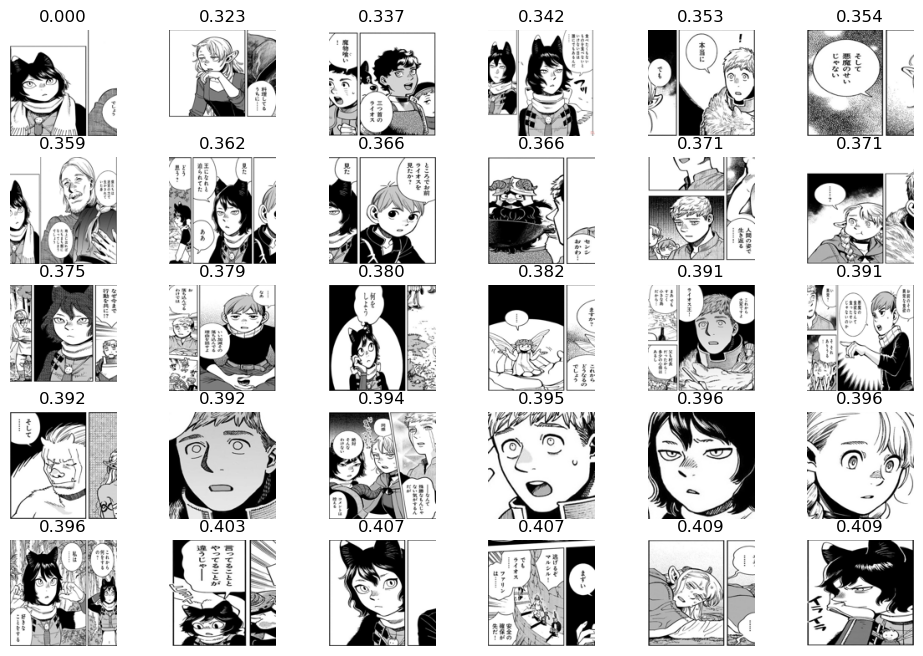

In [10]:
# Nearest-neighbor search with scikit-learn

embs = np.load('data/embeddings.npy')
with open('data/crop_paths.json','r') as f:
    crop_paths = json.load(f)

nn = NearestNeighbors(n_neighbors=50, metric='cosine')
nn.fit(embs)

# Example: set seed_path to one seed Izutsumi crop on your machine
seed_path = 'data/crops/021_panel_4_crop_182.jpg'
if seed_path:
    seed = load_img(seed_path)
    vec = embed_model.predict(seed[np.newaxis,...])
    dists, idxs = nn.kneighbors(vec, n_neighbors=30)
    import matplotlib.pyplot as plt
    from PIL import Image
    plt.figure(figsize=(12,8))
    for i, idx in enumerate(idxs[0]):
        im = Image.open(crop_paths[idx]).convert('RGB')
        plt.subplot(5,6,i+1); plt.imshow(im.resize((128,128))); plt.title(f"{dists[0,i]:.3f}"); plt.axis('off')
    plt.show()
else:
    print('Set seed_path to run a sample query (path to one Izutsumi crop)')
